## Step 2
### Target
1. Add image augmentation w random rotation and random affine to improve the model performance.


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [4]:

cuda = torch.cuda.is_available()
print("CUDA Availalbe: ", cuda)


# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe:  True


## Model

In [5]:
from model import *
Net = Model_2

## Model Params

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

## Training and Testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09585661441087723 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:30<00:00, 15.36it/s] 



Test set: Average loss: 0.0803, Accuracy: 9711/10000 (97.11%)

EPOCH: 1


Loss=0.10386136174201965 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:29<00:00, 15.88it/s] 



Test set: Average loss: 0.0482, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.1041751429438591 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]  



Test set: Average loss: 0.0398, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.08491972088813782 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:28<00:00, 16.22it/s] 



Test set: Average loss: 0.0393, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.058195650577545166 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]



Test set: Average loss: 0.0435, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.14990271627902985 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s] 



Test set: Average loss: 0.0335, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.07844436913728714 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:30<00:00, 15.50it/s] 



Test set: Average loss: 0.0367, Accuracy: 9887/10000 (98.87%)

EPOCH: 7


Loss=0.08345862478017807 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:29<00:00, 15.73it/s] 



Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.053066056221723557 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:29<00:00, 15.81it/s] 



Test set: Average loss: 0.0326, Accuracy: 9883/10000 (98.83%)

EPOCH: 9


Loss=0.04378240928053856 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s] 



Test set: Average loss: 0.0345, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.07655028253793716 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:29<00:00, 15.82it/s] 



Test set: Average loss: 0.0279, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.05242331698536873 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s] 



Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.05842609703540802 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:28<00:00, 16.17it/s]  



Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.09140291064977646 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]  



Test set: Average loss: 0.0277, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.009076264686882496 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]



Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99.16%)



Text(0.5, 1.0, 'Test Accuracy')

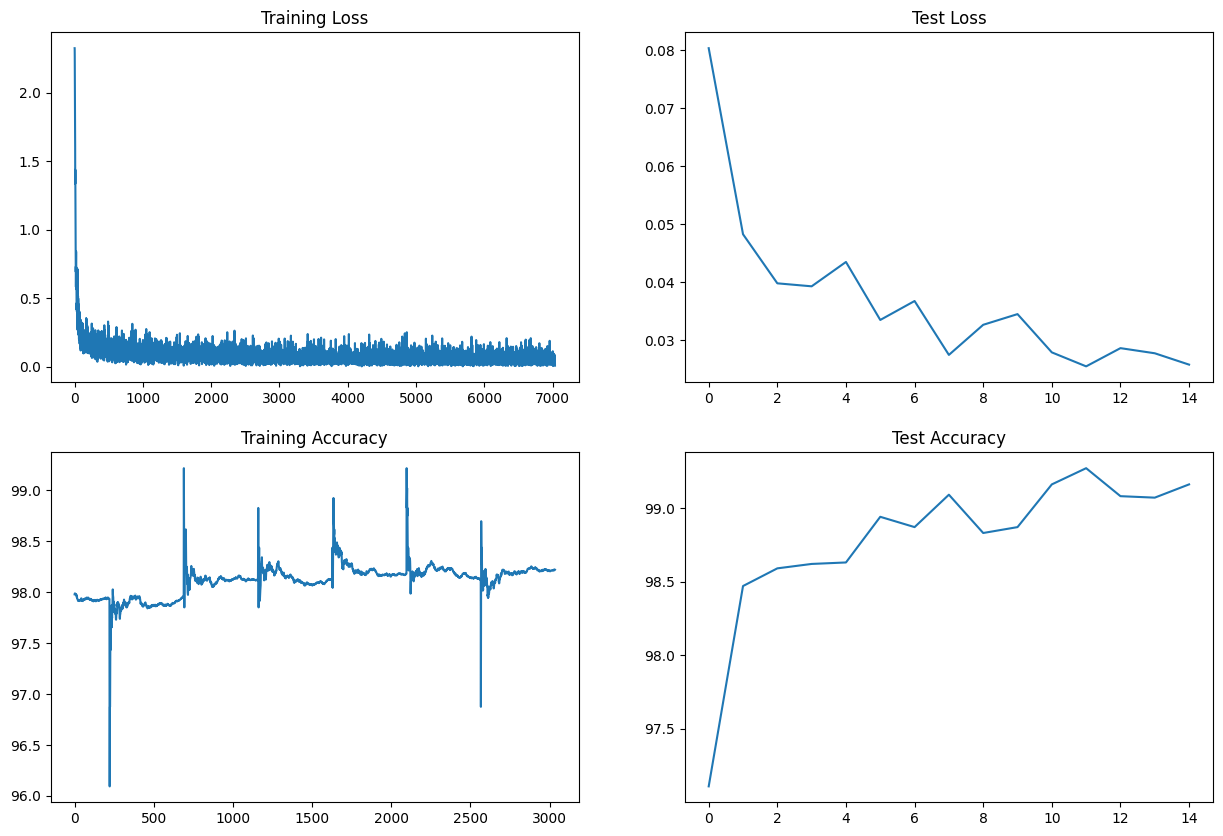

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")